In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

In [ ]:
g = 0

def impure_uses_globals(x):
  return x + g

print("First call: ", jit(impure_uses_globals)(4.))

g = 10.

print("Second call: ", jit(impure_uses_globals)(5.))

First call:  4.0
Second call:  5.0


In [ ]:
seed = 0
state = jax.random.PRNGKey(seed)

state1, state2 = jax.random.split(state)

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0

counter = Counter()

for _ in range(3):
  print(counter.count())

counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

from jax import make_jaxpr

counter.reset()
print(make_jaxpr(counter.count)())

1
2
3
1
1
1
{ lambda ; . let  in (1,) }


In [ ]:
CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3
1
2
3


In [ ]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2

x, y, z, w = [1.]*4
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
print(dfdx, dfdy, dfdz, dfdw)

2.0 2.0 2.0 2.0


In [ ]:
pytree_example = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

for pytree  in pytree_example:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7c57a984bc50>]   has 3 leaves: [1, 'a', <object object at 0x7c57a984bc50>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


<ipython-input-105-278f6f193365>:10: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  leaves = jax.tree_leaves(pytree)


In [ ]:
list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

print(jax.tree.map(lambda x: x*2, list_of_lists))

another_list_of_lists = list_of_lists
print(jax.tree.map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

# PyTrees need to have the same structure if we are to apply three_multimap!
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append([23])
# print(jax.tree.map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]
[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [ ]:
def init_mlp_params(layer_widths):
  params = []

  # Allocate weights and biases
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(widths=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
             )
    )
    return params

# Instantiate a single input - single output, 3 layer (2 hidden layers) deep MLP
params = init_mlp_params([1, 128, 128, 1])

# Another example of how we might use  tree_map - verify that shapes make sense:
jax.tree.map(lambda x: x.shape, params)

[{'biases': (128,), 'widths': (1, 128)}]

In [ ]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)  # MSE loss

lr = 0.0001

@jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)

  return jax.tree.map(
      lambda p, g: p - lr * g, params, grads  # for every lead i.e. for every param of MLP
  )

In [ ]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2


# num_epochs = 5000
# for _ in range(num_epochs):
    # params = update(params, xs, ys)



# Custom PyTrees

In [ ]:
class MyContainer:
  """A named container"""
  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

example_pytree = [MyContainer('Alice', 1, 2, 3), MyContainer('Bob', 4, 5, 6)]

leaves = jax.tree.leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has{len(leaves)} leaves:\n {leaves}")

# print(jax.tree.map(lambda x: x + 1, example_pytree))

[<__main__.MyContainer object at 0x7c57a9103f10>, <__main__.MyContainer object at 0x7c57a9103fa0>]
 has2 leaves:
 [<__main__.MyContainer object at 0x7c57a9103f10>, <__main__.MyContainer object at 0x7c57a9103fa0>]


In [ ]:
def flatten_MyContainer(container):
  """Returns an iterable over container contents, and aux data."""
  flat_contents = [container.a, container.b, container.c]

  aux_data = container.name

  return flat_contents, aux_data

def unflatten_MyContainer(aux_data, flat_contents):
  """Converts aux data and flat contents into a MyContainer."""
  return MyContainer(aux_data, *flat_contents)

# Register a custom PyTree node
jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflatten_MyContainer)

In [ ]:
leaves = jax.tree.leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7c57a9103f10>, <__main__.MyContainer object at 0x7c57a9103fa0>]
 has 6 leaves:
 [1, 2, 3, 4, 5, 6]


In [ ]:
result = jax.tree.map(lambda x: x + 1, example_pytree)
print(jax.tree.leaves(result))

[2, 3, 4, 5, 6, 7]


In [ ]:
zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

[Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)]


In [ ]:
shapes = jax.tree.map(lambda x: x.shape, zeros_tree)
print(shapes)

ones_tree = jax.tree.map(jnp.ones, shapes)
print(ones_tree)

[(2, 3), (3, 4)]
[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)), (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]


In [ ]:
import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

jax.devices()

[CpuDevice(id=0)]

In [ ]:
x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(w, x):
  output = []

  for i in range(1, len(x) - 1):
    output.append(jnp.dot(x[i-1:i+2], w))

  return jnp.array(output)

result = convolve(w, x)
print(repr(result))

Array([11., 20., 29.], dtype=float32)


In [ ]:
n_devices = jax.local_device_count()
print(f"Number of available devices: {n_devices}")

xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

print(xs.shape, ws.shape)

Number of available devices: 1
(1, 5) (1, 3)


In [ ]:
# First way to optimize it is vmap
vmap_result = jax.vmap(convolve)(ws, xs)
print(repr(vmap_result))

Array([[11., 20., 29.]], dtype=float32)


In [ ]:
# If just swap vmap for pmap the running on multiple devices
pmap_result = jax.pmap(convolve)(ws, xs)
print(repr(pmap_result))  # SharedDeviceArray

Array([[11., 20., 29.]], dtype=float32)


In [ ]:
# No cross-device communication costs. Computations are done independently on each dev
double_pmap_result = jax.pmap(convolve)(jax.pmap(convolve)(ws, xs), xs)
print(repr(double_pmap_result))

Array([[ 78., 138., 198.]], dtype=float32)


In [ ]:
# Same results but don;t have to manually broadcast w
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))

Array([[11., 20., 29.]], dtype=float32)


In [ ]:
def normalized_convolution(w, x):
  output = []

  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))

  output = jnp.array(output)

  return output / jax.lax.psum(output, axis_name="batch_dim")  # Here communication happens

res_pmap = jax.pmap(normalized_convolution, axis_name="batch_dim", in_axes=(None, 0))(w, xs)
res_vmap = jax.vmap(normalized_convolution, axis_name="batch_dim", in_axes=(None, 0))(w, xs)

print(repr(res_pmap))
print(repr(res_vmap))

print(f"Verify the output is normalized: {sum(res_pmap[:, 0])}")

Array([[1., 1., 1.]], dtype=float32)
Array([[1., 1., 1.]], dtype=float32)
Verify the output is normalized: 1.0


In [ ]:
def sum_squared_error(x, y):
  return sum((x-y)**2)

x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1

# An efficient way to return both grads and loss value
jax.value_and_grad(sum_squared_error)(x, y)

# def sum_squared_error_with_aux(x, y):
#     return sum((x-y)**2), x-y

# jax.grad(sum_squared_error_with_aux)(x, y)

(Array(0.03999997, dtype=float32),
 Array([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32))

In [ ]:
class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


lr = 0.005


def init_model(rng):
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def forward(params, xs):
  return params.weight * xs + params.bias


def loss_fn(params, xs, ys):
  pred = forward(params, xs)
  return jnp.mean((pred - ys) ** 2)  # MSE

@functools.partial(jax.pmap, axis_name='batch')
def update(params, xs, ys):

    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='batch')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='batch')

    # Each device performs its own SGD update, but since we start with the same params
    # and synchronise gradients, the params stay in sync on each device.
    new_params = jax.tree.map(
        lambda param, g: param - g * lr, params, grads)

    return new_params, loss

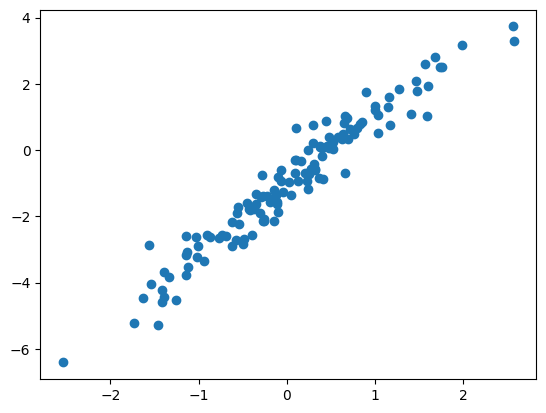

In [ ]:
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

plt.scatter(xs, ys)
plt.show()

In [ ]:
# Initialize parameters and replicate across devices
params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree.map(lambda x: jnp.array([x] * n_devices), params)
print(replicated_params)

def reshape_for_pmap(data, n_devices):
  return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

Params(weight=Array([0.14389051], dtype=float32), bias=Array([-1.2515389], dtype=float32))
(1, 128, 1) (1, 128, 1)


In [ ]:
def type_after_update(name, obj):
  print(f"After first update(), {name} is a {type(obj)}")

num_epochs = 1000
for epoch in range(num_epochs):
  # Here the params and data gets communicated to devices
  replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

  # Replicated_params and loss are no both SharedDeviceArrays
  # Incidacting that they're on the devices
  # x/y_parallel remains a NumPy array on the host (simulating data streaming)
  if epoch == 0:
    type_after_update("replicated_params.weight", replicated_params.weight)
    type_after_update("loss", loss)
    type_after_update("x_parallel", x_parallel)

  if epoch % 100 == 0:
    print(loss.shape)
    print(f"Step {epoch:.3f}, loss: {loss[0]:.3f}")

params = jax.device_get(jax.tree.map(lambda x: x[0], replicated_params))

After first update(), replicated_params.weight is a <class 'jaxlib.xla_extension.ArrayImpl'>
After first update(), loss is a <class 'jaxlib.xla_extension.ArrayImpl'>
After first update(), x_parallel is a <class 'numpy.ndarray'>
(1,)
Step 0.000, loss: 0.235
(1,)
Step 100.000, loss: 0.235
(1,)
Step 200.000, loss: 0.235
(1,)
Step 300.000, loss: 0.235
(1,)
Step 400.000, loss: 0.235
(1,)
Step 500.000, loss: 0.235
(1,)
Step 600.000, loss: 0.235
(1,)
Step 700.000, loss: 0.235
(1,)
Step 800.000, loss: 0.235
(1,)
Step 900.000, loss: 0.235


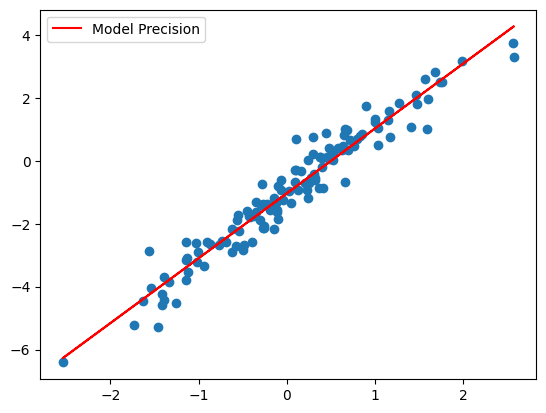

In [ ]:
plt.scatter(xs, ys)
plt.plot(xs, forward(params, xs), c='red', label='Model Precision')
plt.legend()
plt.show()

In [ ]:
# Value function (simple linear fn) and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

# Example transition
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0])

def td_loss(theta, s_tm1, r_t, s_t):
  v_tm1 = value_fn(theta, s_tm1)
  target = r_t + value_fn(theta, s_t)
  return (jax.lax.stop_gradient(target) - v_tm1) ** 2

In [ ]:
# Per sample gradients

# Batch the data
batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))
perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)